In [2]:
import glob
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use("ggplot")

In [42]:
white_data = pd.DataFrame()
black_data = pd.DataFrame()

def yield_orgin_csv(pd_name, file_type):
    all_api_names, all_call_pids, all_ret_values, all_exinfos = [], [], [], []
    flag = 1
    for path in glob.glob("./stage1_dataset/train/{}/*".format(file_type)):
        with open(path, "r") as fp:
            xml = BeautifulSoup(fp, "lxml")
        action = xml.find_all("action")
        api_names, call_pids, ret_values, exinfos = [], [], [], []
        for a in action:
            try:
                api_names.append(a.get("api_name"))
            except:
                api_names.append("")
            try:
                call_pids.append(a.get("call_pid"))
            except:
                call_pids.append("")
            try:
                ret_values.append(a.get("ret_value"))
            except:
                ret_values.append("")
            try:
                for exinfo in a.find_all("exinfo"):
                    exinfos.append(exinfo.get("value"))
            except:
                exinfos.append("")
        try:
            all_api_names.append(" ".join(api_names))
        except:
            all_api_names.append("")
        try:
            all_call_pids.append(" ".join(call_pids))
        except:
            all_call_pids.append("")
        try:
            all_ret_values.append(" ".join(ret_values))
        except:
            all_ret_values.append("")
        try:
            all_exinfos.append(" ".join(exinfos))
        except:
            all_exinfos.append("")
        
        
        if flag % 300 == 0:
            print(flag)
        flag += 1
        
    pd_name["api_name"] = all_api_names
    pd_name["call_pid"] = all_call_pids
    pd_name["ret_value"] = all_ret_values
    pd_name["exinfos"] = all_exinfos
    pd_name.to_csv("{}_data.csv".format(file_type), index=False, encoding="utf-8")

In [44]:
yield_orgin_csv(white_data, "white")
yield_orgin_csv(white_data, "black")

In [104]:
# 拼接black_data和white_data
black_data = pd.read_csv("black_data.csv", encoding="iso8859-1")
white_data = pd.read_csv("white_data.csv", encoding="utf-8")
origin_train_data = pd.concat([black_data, white_data])
safe_type = [1 for _ in range(black_data.shape[0])] + [0 for _ in range(white_data.shape[0])]
origin_train_data["safe_type"] = safe_type
origin_train = origin_train_data.dropna(how="any")
origin_train.to_csv("origin_train_data.csv", encoding="utf-8", index=False)

In [4]:
train_data = pd.read_csv("origin_train_data.csv")

In [3]:
train_data.head()

,api_name,call_pid,ret_value,exinfos,safe_type
0,AnalyzeStart Fake_BeCreatedEx TryToAnalyze Loa...,0 396 396 396 396 396 396 396 396 396 396 396 ...,0 0 0 0 0 0 0 0 0 0 0 c0000034 0 0 0 c0000034 ...,"SyStem.exe 212 ""C:\program\1.exe"" direct C:\p...",0
1,AnalyzeStart Fake_BeCreatedEx TryToAnalyze Loa...,0 396 396 396 396 396 396 396 396 396 396 396 ...,0 0 0 0 0 0 0 0 0 c0000034 0 c0000034 0 c00000...,"SyStem.exe 212 ""C:\program\1.exe"" direct C:\p...",0
2,AnalyzeStart Fake_BeCreatedEx TryToAnalyze Loa...,0 396 396 396 396 396 396 396 396 396 396 396 ...,0 0 0 0 0 0 0 0 0 0 0 0 0 c0000034 0 c0000034 ...,"SyStem.exe 212 ""C:\program\1.exe"" direct C:\p...",0
3,AnalyzeStart Fake_BeCreatedEx TryToAnalyze Loa...,0 396 396 396 396 396 396 396 396 396 396 396 ...,0 0 0 0 0 0 0 0 0 0 0 c0000034 0 0 0 0 c000003...,"SyStem.exe 212 ""C:\program\1.exe"" direct C:\p...",0
4,AnalyzeStart Fake_BeCreatedEx TryToAnalyze Loa...,0 396 396 396 396 396 396 396 396 396 396 396 ...,0 0 0 0 0 0 0 0 0 0 0 0 c0000034 0 c0000034 0 ...,"SyStem.exe 212 ""C:\program\1.exe"" direct C:\p...",0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29979 entries, 0 to 29978
Data columns (total 5 columns):
api_name     29979 non-null object
call_pid     29979 non-null object
ret_value    29979 non-null object
exinfos      29979 non-null object
safe_type    29979 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [3]:
def adjust_index_string(keys_set, length=12):
    keys = []
    for key in keys_set:
        if len(key) > length:
            keys.append(key[:12])
        else:
            keys.append(key)
    return keys
    
def plot_and_compute_top_features(origin_train_data, column, plot=False):
    black_api_names = origin_train_data[origin_train_data["safe_type"] == 1]["{}".format(column)]
    white_api_names = origin_train_data[origin_train_data["safe_type"] == 0]["{}".format(column)]
    black_api_name_list = [name for black in black_api_names for name in black.split()]
    white_api_name_list = [name for white in white_api_names for name in white.split()] 
    black_counter = Counter(black_api_name_list)
    white_counter = Counter(white_api_name_list)
    black_api_name_pd = pd.DataFrame()
    black_api_name_pd["count"] = black_counter.values()
    black_api_name_pd.index = adjust_index_string(black_counter.keys())
    
    white_api_name_pd = pd.DataFrame()
    white_api_name_pd["count"] = white_counter.values()
    white_api_name_pd.index = adjust_index_string(white_counter.keys())
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(25, 8))
        black_api_name_pd.sort_values(by="count", ascending=True)[-30:].plot(kind="barh", ax=axs[0])
        axs[0].set_title("black_sample")
        white_api_name_pd.sort_values(by="count", ascending=True)[-30:].plot(kind="barh", ax=axs[1])
        axs[1].set_title("white_sample")
        plt.tight_layout()
        fig.savefig("{}_barh.pdf".format(column))
    return black_api_name_pd.sort_values(by="count", ascending=True).index

In [90]:
# api_name_index = plot_and_compute_top_features(train, "api_name", plot=True)
# call_pid_index = plot_and_compute_top_features(train, "call_pid", plot=True)
# exinfos_index = plot_and_compute_top_features(train, "exinfos", plot=True)
# ret_values_index = plot_and_compute_top_features(train, "ret_value", plot=True)

In [165]:
def compute_diff_features(train_data, column, plot=False):
    black_api_names = train_data[train_data["safe_type"] == 1]["{}".format(column)]
    white_api_names = train_data[train_data["safe_type"] == 0]["{}".format(column)]
    black_api_name_set = set([name for black in black_api_names for name in black.split()])
    white_api_name_set = set([name for white in white_api_names for name in white.split()]) 
    return black_api_name_set.symmetric_difference(white_api_name_set)

In [17]:
# api_name_diff = compute_diff_features(origin_train, "api_name")
# call_pid_diff = compute_diff_features(origin_train, "call_pid")

In [14]:
# 处理test数据集
def yield_orgin_test_csv(pd_name, file_type):
    all_api_names, all_call_pids, all_ret_values, all_exinfos, id_ = [], [], [], [], []
    flag = 1
    for path in glob.glob("./stage1_dataset/{}/*".format(file_type)):
        with open(path, "r") as fp:
            xml = BeautifulSoup(fp, "lxml")
        action = xml.find_all("action")
        api_names, call_pids, ret_values, exinfos = [], [], [], []
        for a in action:
            try:
                api_names.append(a.get("api_name"))
            except:
                api_names.append("")
            try:
                call_pids.append(a.get("call_pid"))
            except:
                call_pids.append("")
            try:
                ret_values.append(a.get("ret_value"))
            except:
                ret_values.append("")
            try:
                for exinfo in a.find_all("exinfo"):
                    exinfos.append(exinfo.get("value"))
            except:
                exinfos.append("")
        try:
            all_api_names.append(" ".join(api_names))
        except:
            all_api_names.append("")
        try:
            all_call_pids.append(" ".join(call_pids))
        except:
            all_call_pids.append("")
        try:
            all_ret_values.append(" ".join(ret_values))
        except:
            all_ret_values.append("")
        try:
            all_exinfos.append(" ".join(exinfos))
        except:
            all_exinfos.append("")
        id_.append(path.split('.')[1].split('/')[-1]) 
        
        
        if flag % 300 == 0:
            print(flag)
        flag += 1
        
    pd_name["api_name"] = all_api_names
    pd_name["call_pid"] = all_call_pids
    pd_name["ret_value"] = all_ret_values
    pd_name["exinfos"] = all_exinfos
    pd_name["id"] = id_
    pd_name.to_csv("{}_data.csv".format(file_type), index=False, encoding="utf-8")

In [15]:
test_pd = pd.DataFrame()

In [17]:
yield_orgin_test_csv(test_pd, "test")

In [19]:
test_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
api_name     15000 non-null object
call_pid     15000 non-null object
ret_value    15000 non-null object
exinfos      15000 non-null object
id           15000 non-null object
dtypes: object(5)
memory usage: 586.0+ KB


In [5]:
api_name_index = plot_and_compute_top_features(train_data, "api_name")
call_pid_index = plot_and_compute_top_features(train_data, "call_pid")
exinfos_index = plot_and_compute_top_features(train_data, "exinfos")
ret_values_index = plot_and_compute_top_features(train_data, "ret_value")
def yield_last_data_set(pd_name, 
                        api_name_index, 
                        call_pid_index, 
                        ret_values_index,
                        exinfos_index, 
                        type_):
    api_name_set = api_name_index[-80:]
    call_pid_set = list(call_pid_index[-12:]) + ["1396", "2692", "2672", "2696"]
    exinfos_set = exinfos_index[-20:]
    ret_value_set = ret_values_index[-20:]
    
    for feature in api_name_set:
        pd_name[feature] = pd_name["api_name"].apply(lambda x: x.split().count(feature))
    for feature in call_pid_set:
        pd_name[feature] = pd_name["call_pid"].apply(lambda x: x.split().count(feature))
    for feature in exinfos_set:
        pd_name[feature] = pd_name["exinfos"].apply(lambda x: x.split().count(feature))
    for feature in ret_value_set:
        pd_name[feature] = pd_name["ret_value"].apply(lambda x: x.split().count(feature))
        
    new = pd_name.drop(["api_name", "call_pid", "ret_value", "exinfos"], axis=1)
    new_pd = new.sample(frac=1.0)
    new_pd.to_csv("{}.csv".format(type_), index=False, encoding="utf-8")
    return new_pd

In [8]:
test_data = pd.read_csv("origin_test_data.csv")
fliter_test_data_2 = yield_last_data_set(test_data, 
                                         api_name_index, 
                                         call_pid_index, 
                                         ret_values_index,
                                         exinfos_index, 
                                         "fliter_test_data_2")

In [7]:
origin_train = pd.read_csv("origin_train_data.csv")
fliter_train_data_2 = yield_last_data_set(origin_train, 
                                          api_name_index, 
                                          call_pid_index,
                                          ret_values_index,
                                          exinfos_index,
                                          "fliter_train_data_2")

In [10]:
safe_type = fliter_train_data_2["safe_type"]
features = fliter_train_data_2.iloc[:, 2:]

In [15]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

train_data, test_data, train_label, test_label = train_test_split(features, 
                                                                  safe_type, 
                                                                  test_size=0.2, 
                                                                  random_state=0)
def plot(test_label, y_pred, model):
    font = {"color": "darkred",
            "size": 13, 
            "family" : "serif"}

    accs = accuracy_score(test_label, y_pred)
    fpr, tpr, _ = metrics.roc_curve(test_label,  y_pred)
    auc = metrics.roc_auc_score(test_label, y_pred)
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="{}, auc=".format(model)+str(auc), color='green', linewidth=2)
    ax.set_title("ROC curve", fontdict=font)
    leg = ax.legend(loc="best")
    text = leg.get_texts()
    _ = plt.setp(text, color="blue") 

In [12]:
def calc_score(y_pred, test_label):
    return (((y_pred == test_label).sum(axis=0)
            - (y_pred - test_label) @ y_pred) 
            / y_pred.shape[0])

In [13]:
model = XGBClassifier()               
model.fit(train_data, train_label)            
y_pred = model.predict(test_data)

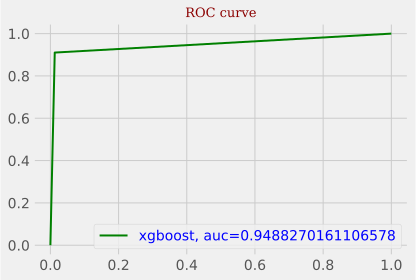

In [16]:
plot(test_label, y_pred, "xgboost")

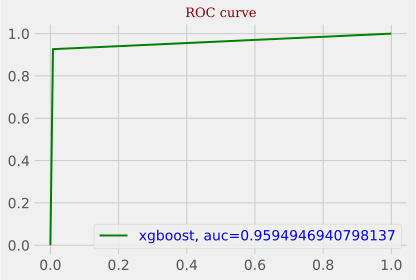

In [46]:
plot(test_label, y_pred, "xgboost")

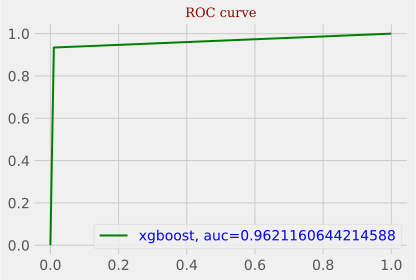

In [200]:
plot(test_label, y_pred, "xgboost")

In [48]:
from sklearn.metrics import classification_report
target_names = ["class_0", "class_1"]
print(classification_report(y_pred, test_label, target_names=target_names))

              precision    recall  f1-score   support

     class_0       0.99      0.96      0.98      4073
     class_1       0.93      0.98      0.95      1923

   micro avg       0.97      0.97      0.97      5996
   macro avg       0.96      0.97      0.97      5996
weighted avg       0.97      0.97      0.97      5996



In [84]:
test = pd.read_csv("test.csv")
id_ = test["id"]
test_features = test.iloc[:, 1:]

In [85]:
predict = model.predict(test_features)

In [86]:
result = pd.DataFrame()
result["id"] = id_
result["safe_type"] = predict

In [87]:
result.to_csv("result.csv", encoding="utf-8", index=False)

In [153]:
calc_score(y_pred, test_label)

0.9566377585056705

In [162]:
calc_score(y_pred, test_label)

0.9633088725817212

In [202]:
calc_score(y_pred, test_label)

0.9643095396931287

In [51]:
calc_score(y_pred, test_label)

0.9649766511007338

In [17]:
calc_score(y_pred, test_label)

0.9531354236157439